In [1]:
using XLSX
using Plots
using JLD

include("FCSeqTools.jl");

In [3]:
dms = do_number_matrix_prot(do_letter_matrix("dms.faa"), 0.2);
gen = do_number_matrix_prot(do_letter_matrix("gen.faa"), 0.2);
nat = do_number_matrix_prot(do_letter_matrix("nat.faa"), 0.2);

wt_seq = nat[1,:];

In [4]:
function read_fasta(filename, threshold)
    out = do_number_matrix_prot(do_letter_matrix(filename), threshold)
    f = open(filename)
    lines = readlines(f)
    lines = lines[lines.!=""]
    out_re = []
    out_E = []
    for line in lines
        if line[1] == '>'
            num, re_E = split(line, " re_")
            re, E = split(re_E, " E_")
            print(re, " ", E, "\n")
            push!(out_re, parse(Float64, re))
            push!(out_E, parse(Float64, E))
        end
    end
    return out, out_re, out_E
end

read_fasta (generic function with 1 method)

In [5]:
nat_MSA, nat_re, nat_E = read_fasta("nat.faa", 0.2);
gen_MSA, gen_re, gen_E = read_fasta("gen.faa", 0.2);
dms_MSA, dms_re, dms_E = read_fasta("dms.faa", 0.2);

L_nat = length(nat_MSA[:,1])
L_gen = length(gen_MSA[:,1])
L_dms = length(dms_MSA[:,1])

0 0
-2.5665 28.6234
-2.3236 -4.1906
-0.84508 8.5705
-2.6241 18.415
-0.73415 9.8302
-0.12908 6.4199
-2.5684 27.8296
-0.38102 26.2519
-2.5523 26.5771
-3.0756 24.5726
-0.27307 4.7347
-1.8368 27.1543
-1.7088 2.818
-0.35952 2.1501
-1.221 21.5435
-0.39834 1.2315
-0.45139 -1.2016
0.058137 -1.5677
-2.6005 20.2151
-2.6771 15.0872
-0.27642 -3.8364
-0.050129 -3.5797
-2.4946 6.6987
-0.22891 15.2139
-2.5239 2.526
-1.1006 5.9174
-0.28304 4.234
-2.5714 14.549
-1.9273 11.079
-2.0868 5.6992
-0.0025689 -0.406
-1.7504 -4.4033
-2.0779 2.4201
-1.371 -7.4756
-2.8394 7.7262
-2.1904 3.7339
-2.2466 4.651
-0.38337 0.71535
-2.2234 1.31
-2.5896 1.8926
-2.0835 -0.32736
-1.6349 -6.0985
-1.0596 2.4186
-1.9857 13.8074
-1.4812 16.1228
-2.2902 0.53233
-0.20546 6.4037
-2.9238 3.8464
-2.0181 3.7083
-1.8217 13.8944
-2.383 23.8477
-0.27947 8.3247
-2.558 4.9167
-3.361 8.0481
-2.7702 9.5922
-0.44427 13.9963
-1.7715 19.9167
-0.97328 12.972
-1.7824 14.7284
-2.1059 -1.0855
-2.4035 -2.095
-2.9238 1.5894
-2.6482 13.3785
-2.3733 1

1773

# Energies

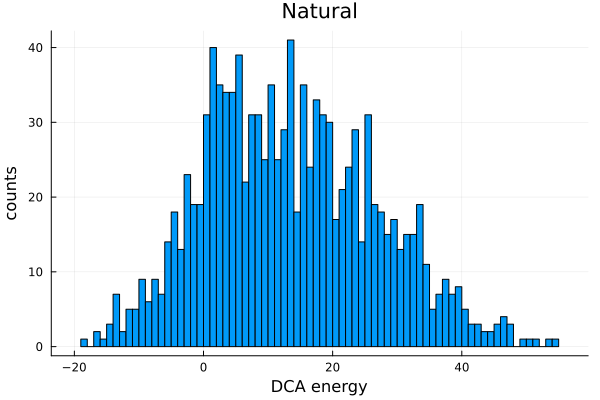

In [6]:
histogram(nat_E, bins=100, title= "Natural", xlabel="DCA energy", ylabel="counts", label=:false)

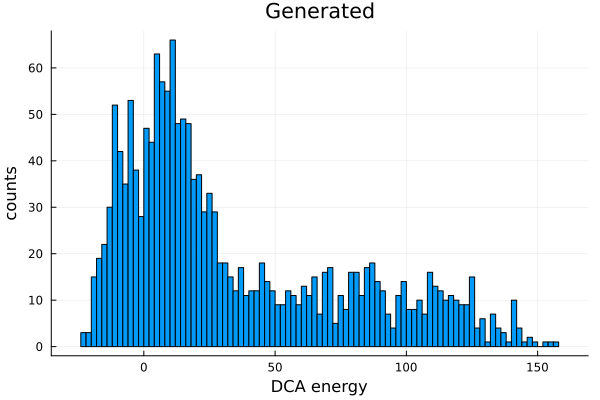

In [7]:
histogram(gen_E, bins=100, title= "Generated", xlabel="DCA energy", ylabel="counts", label =:false)

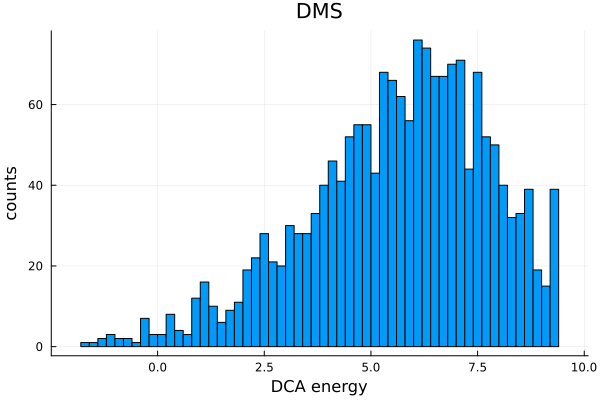

In [8]:
histogram(dms_E, bins=100, title= "DMS", xlabel="DCA energy", ylabel="counts", label=:false)

# Relative Enrichment

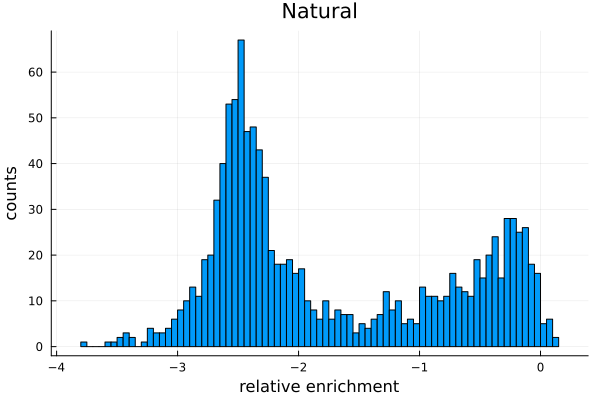

In [9]:
histogram(nat_re, bins=100, title= "Natural", xlabel="relative enrichment", ylabel="counts", label=:false)

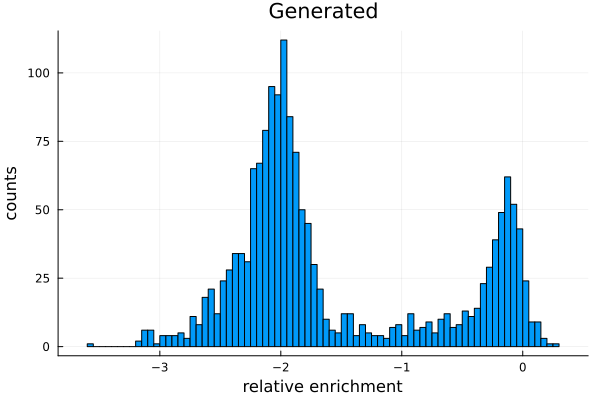

In [10]:
histogram(gen_re, bins=100, title= "Generated", xlabel="relative enrichment", ylabel="counts", label=:false)

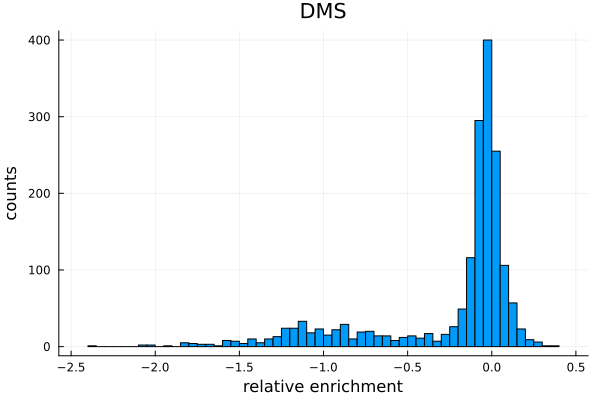

In [11]:
histogram(dms_re, bins=100, title= "DMS", xlabel="relative enrichment", ylabel="counts", label=:false)

# Comparison with EAA

In [52]:
# FULL MODEL ENERGIES
function full_model_energy(q, fields, couplings, MSA, L_MSA)
    full_energies = []
    for i in 1:L_MSA
        seq = MSA[i,:]' 
        freq = freq_single_point(seq, q, 0.0) 
        fij = fij_two_point(seq, q, 0.0)
        push!(full_energies, - sum(fij .* couplings) - sum(freq .* fields))
    end
    return full_energies
end

full_model_energy (generic function with 1 method)

In [53]:
method = "cumulative"
fraction = 0.3
stop = 0.95
folder_name = method*string(fraction)*"_stop="*string(stop)
folder_path = "/Users/robertonetti/Documents/GitHub/FCSeqTools.jl/Example_Proteins/"*folder_name*"/"  

fields_model = JLD.load(folder_path*"h.jld")["data"]
couplings_model = JLD.load(folder_path*"Jij.jld")["data"];

In [54]:
# WILD TYPE
q = 21
wt_freq = freq_single_point(wt_seq', q, 0.0) 
wt_fij = fij_two_point(wt_seq', q, 0.0)
wt_E = - sum(wt_fij .* couplings_model) - sum(wt_freq .* fields_model)
# MSAs
nat_model_energy = full_model_energy(q, fields_model, couplings_model, nat_MSA, L_nat);
gen_model_energy = full_model_energy(q, fields_model, couplings_model, gen_MSA, L_gen);
dms_model_energy = full_model_energy(q, fields_model, couplings_model, dms_MSA, L_dms);

In [55]:
# SUBTRACT WT ENERGY
nat_model_energy .-= wt_E
gen_model_energy .-= wt_E
dms_model_energy .-= wt_E;

In [76]:
using StatsBase

# correlations
print("Correlations over the NATURAL dataset \n")
print("DCA: Pearson(E,re): ", cor(nat_E, nat_re), ";   Spearman(E,re): ", corspearman(Float64.(nat_E), Float64.(nat_re)),";\n")
print("EAA: Pearson(E,re): ", cor(nat_model_energy, nat_re), ";   Spearman(E,re): ", corspearman(Float64.(nat_model_energy), Float64.(nat_re)),";\n\n")
print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(nat_E, nat_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(nat_E), Float64.(nat_model_energy)),";\n")


Correlations over the NATURAL dataset 
DCA: Pearson(E,re): 0.04756017556687371;   Spearman(E,re): 0.035177801098107545;
EAA: Pearson(E,re): 0.033782800055780264;   Spearman(E,re): 0.049605102715988086;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.19801837052651658;   Spearman(E_DCA,E_EAA): 0.19212863404785122;


In [77]:
# correlations
print("Correlations over the DMS dataset \n")
print("DCA: Pearson(E,re): ", cor(dms_E, dms_re), ";   Spearman(E,re): ", corspearman(Float64.(dms_E), Float64.(dms_re)),";\n")
print("EAA: Pearson(E,re): ", cor(dms_model_energy, dms_re), ";   Spearman(E,re): ", corspearman(Float64.(dms_model_energy), Float64.(dms_re)),";\n\n")

print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(dms_E, dms_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(dms_E), Float64.(dms_model_energy)),";\n")


Correlations over the DMS dataset 
DCA: Pearson(E,re): -0.39714540790230124;   Spearman(E,re): -0.3160540444689717;
EAA: Pearson(E,re): 0.09569084711442521;   Spearman(E,re): 0.11940157000993028;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.36731655429670385;   Spearman(E_DCA,E_EAA): 0.28800971824163313;


In [78]:
# correlations
print("Correlations over the GENERATED dataset \n")
print("DCA: Pearson(E,re): ", cor(gen_E, gen_re), ";   Spearman(E,re): ", corspearman(Float64.(gen_E), Float64.(gen_re)),";\n")
print("EAA: Pearson(E,re): ", cor(gen_model_energy, gen_re), ";   Spearman(E,re): ", corspearman(Float64.(gen_model_energy), Float64.(gen_re)),";\n\n")

print("DCA vs EAA: Pearson(E_DCA,E_EAA): ", cor(gen_E, gen_model_energy), ";   Spearman(E_DCA,E_EAA): ", corspearman(Float64.(gen_E), Float64.(gen_model_energy)),";\n")


Correlations over the GENERATED dataset 
DCA: Pearson(E,re): -0.4365373906934347;   Spearman(E,re): -0.40938012155808373;
EAA: Pearson(E,re): -0.4476954639632012;   Spearman(E,re): -0.42363994866768456;

DCA vs EAA: Pearson(E_DCA,E_EAA): 0.9807882570862565;   Spearman(E_DCA,E_EAA): 0.9576446005901449;


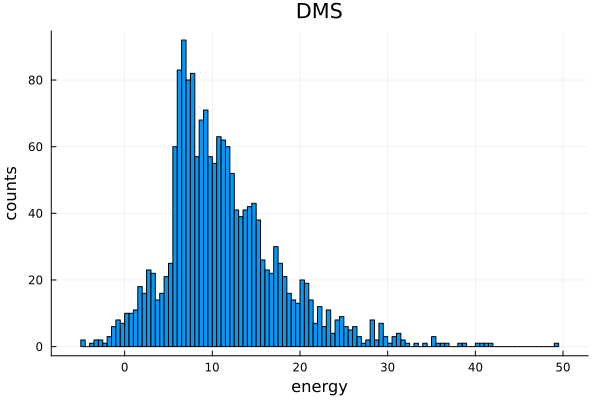

In [96]:
histogram(dms_model_energy, bins=100, title= "DMS", xlabel="energy", ylabel="counts", label=:false)

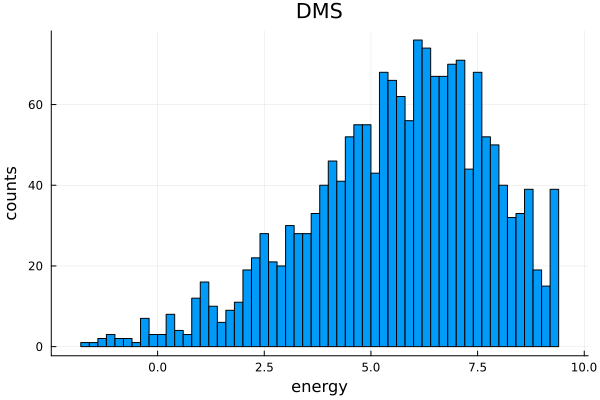

In [97]:
histogram(dms_E, bins=100, title= "DMS", xlabel="energy", ylabel="counts", label=:false)

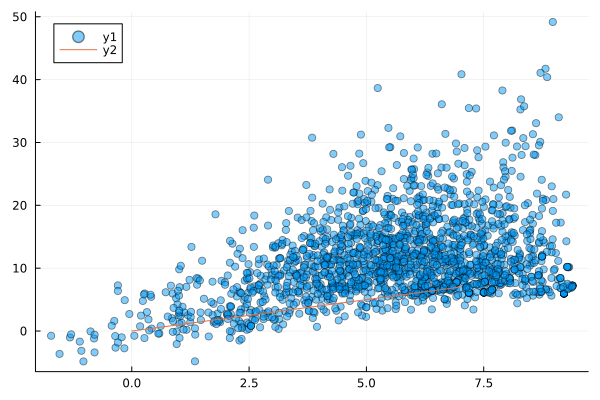

In [101]:
scatter(dms_E, dms_model_energy, alpha=0.5, )
plot!(x,y)

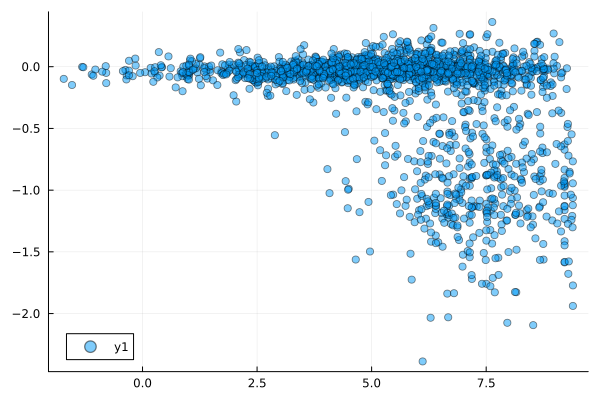

In [102]:
scatter(dms_E, dms_re, alpha=0.5, )
#plot!(x,y)

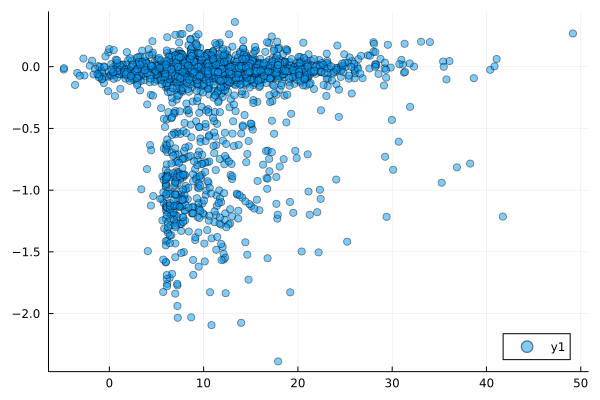

In [103]:
scatter(dms_model_energy, dms_re, alpha=0.5, )

In [112]:
vec(couplings_model)[vec(couplings_model).!=0]

69673-element Vector{Float32}:
  2.1249745
  0.53690195
  0.5112916
 -0.76732314
  0.68555474
 -0.48767963
  0.48447233
  0.45706174
  1.1474767
  0.690764
  0.8956856
  0.48194098
  0.4995869
  ⋮
  0.8008751
  1.9555051
 -0.32641736
  1.4863194
  0.32160518
  0.6943976
  1.3152168
  2.08253
  0.44456717
  0.41429663
  2.0343816
  1.6952896

In [113]:
vec(couplings_model)

4064256-element Vector{Float32}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 2.08253
 0.0
 0.44456717
 0.41429663
 2.0343816
 1.6952896
 0.0

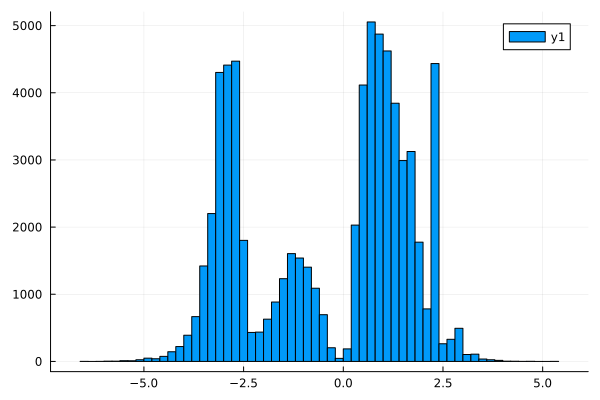

In [109]:
histogram(vec(couplings_model)[vec(couplings_model).!=0])

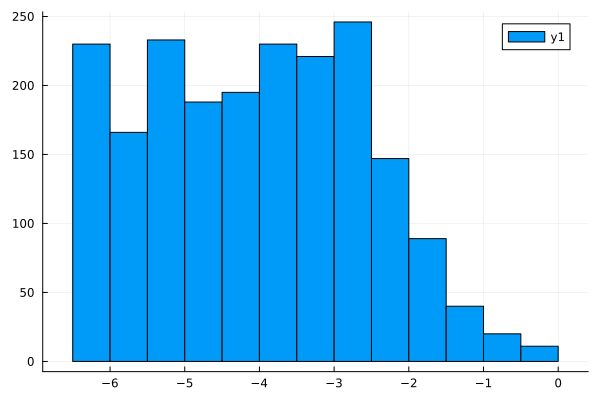

In [114]:
histogram(fields_model)

In [116]:
log(0.05/21)

-6.040254711277414

In [104]:
exp(9)


8103.083927575384

In [106]:
log(10_000)

9.210340371976184

In [107]:
maximum(dms_E)

9.393

In [100]:
x=[0, 1, 3, 7]
y = x

4-element Vector{Int64}:
 0
 1
 3
 7

In [86]:
our_MSA = do_number_matrix_prot(do_letter_matrix("CM_130530_MC.fasta"), 0.2);

In [94]:

for i in 1:length(nat_MSA[:,1])
    for j in 1:length(our_MSA[:,1])
        if nat_MSA[1,:] == our_MSA[1,:]
    end
end


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


LoadError: InterruptException:

In [95]:
crossed_MSA = zeros(length(nat_MSA[:,1]), 96)

1130×96 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0